In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error,mean_absolute_error
from ipywidgets import interact
from scipy.stats import norm

# Cálculo del VaR método paramétrico

# Calculo de rendimientos

In [2]:
port_path = "PreciosPortf.xlsx"
data = pd.read_excel(port_path, index_col=0)

rend = data.pct_change().dropna()

rend_ports = rend.mean()
rend_ports

ASURB MF Equity       0.000490
GFNORTEO MF Equity    0.000313
PE&OLES* MF Equity    0.000441
WALMEX* MF Equity     0.000327
IENOVA* MF Equity     0.000313
dtype: float64

# Creación de la matriz de varianzas y covarianzas sobre los rendimientos

**Anualizada**

In [3]:
macv_a=rend.cov()*252
macv_a

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
ASURB MF Equity,0.056395,0.021719,0.015274,0.009059,0.011079
GFNORTEO MF Equity,0.021719,0.086023,0.023718,0.020604,0.020555
PE&OLES* MF Equity,0.015274,0.023718,0.138051,0.010318,0.011368
WALMEX* MF Equity,0.009059,0.020604,0.010318,0.054222,0.010804
IENOVA* MF Equity,0.011079,0.020555,0.011368,0.010804,0.056846


**Diaria**

In [4]:
macv=rend.cov()
macv

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
ASURB MF Equity,0.000224,0.000086,0.000061,0.000036,0.000044
GFNORTEO MF Equity,0.000086,0.000341,0.000094,0.000082,0.000082
PE&OLES* MF Equity,0.000061,0.000094,0.000548,0.000041,0.000045
WALMEX* MF Equity,0.000036,0.000082,0.000041,0.000215,0.000043
IENOVA* MF Equity,0.000044,0.000082,0.000045,0.000043,0.000226


**Usamos los pesos optimos de sharpe del ejercicio de clase**

In [5]:
#Pesos Sharpe
w_sharpe=np.array([0.68160871, 0.        , 0.15915732, 0.12519673, 0.03403724])
w_alt=np.array([ .24549192, .05227278,  .12184614,  .30259055,  0.27779861])
w_alt.sum()

1.0

In [6]:
# rendimiento esperado (anualizado) de portafolio
(rend.mean() * w_sharpe).sum() * 252

0.11488868216309914

In [7]:
initial_investment = 10000000

# VaR de cada acción 

In [8]:
#Hacemos el vector de posiciones..
Vector_pos=w_sharpe*initial_investment
#Calculamos volatilidad diaria y anual
vol_diaria=np.sqrt(np.diag(macv))
vol_anual=np.sqrt(np.diag(macv_a))
portaf=pd.DataFrame(np.transpose([Vector_pos,vol_diaria,vol_anual]),columns=["Vector_pos","vol_diaria","vol_anual"])
portaf.index=rend.columns

portaf['VaR95_diario']=norm.ppf(.95)*portaf['vol_diaria']*portaf['Vector_pos']
portaf['VaR99_diario']=norm.ppf(.99)*portaf['vol_diaria']*portaf['Vector_pos']
portaf['VaR95_anual']=norm.ppf(.95)*portaf['vol_anual']*portaf['Vector_pos']
portaf['VaR99_anual']=norm.ppf(.99)*portaf['vol_anual']*portaf['Vector_pos']
sal=portaf.sum(axis=0)
portaf

,Vector_pos,vol_diaria,vol_anual,VaR95_diario,VaR99_diario,VaR95_anual,VaR99_anual
ASURB MF Equity,6816087.1,0.014960,0.237477,167719.424422,237208.782622,2.662463e+06,3.765573e+06
GFNORTEO MF Equity,0.0,0.018476,0.293297,0.000000,0.000000,0.000000e+00,0.000000e+00
PE&OLES* MF Equity,1591573.2,0.023406,0.371552,61273.616589,86660.445252,9.726885e+05,1.375692e+06
WALMEX* MF Equity,1251967.3,0.014669,0.232857,30207.058983,42722.419974,4.795222e+05,6.781974e+05
IENOVA* MF Equity,340372.4,0.015019,0.238424,8408.762666,11892.673507,1.334850e+05,1.887903e+05


# Usando los pesos óptimos de sharpe calculamos la media y desviación del portafolio

**Rendimiento y desv diaria**

In [9]:
E_p = (rend.mean() @ w_sharpe)
S_p = np.sqrt(w_sharpe.T @ (rend.cov()) @ w_sharpe)

**Rendimiento y desv anualizado**

In [10]:
E_pa = (rend.mean() @ w_sharpe*252)
S_pa = np.sqrt(w_sharpe.T @ (rend.cov()*252) @ w_sharpe)

In [11]:
# rendimentos esperados diarios y anualizados
mean_investment = (1+E_p) * initial_investment
mean_investment_a = (1+E_pa) * initial_investment

In [12]:
# standard deviation diaria y anualizada
stdev_investment = initial_investment * S_p
stdev_investment_a = initial_investment * S_pa

# Método Var_cov_var del Portafolio

**A diferencia de lo utilizado en el excel se utiliza $N\sim(P*(1+E_p),P*S_p^2)$ para la normalización en vez de una $N\sim(0,1)$ ya que estamos ajustando una normal con los parámetros de la distribución del rendimiento, usando $P$ como la inversión inicial.**

# Calculamos la inversa de la normal con un intervalo de confianza especifico, usando la media E_p y desviacion S_p

**Diario**

In [13]:
# Seleccionamos el nivel de confianza:
conf_level1 = 1-0.95
conf_level2 = 1-.99
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
cutoff2 = norm.ppf(conf_level2, mean_investment, stdev_investment)

**Anualizado**

In [14]:
cutoff1a = norm.ppf(conf_level1, mean_investment_a, stdev_investment_a)
cutoff2a = norm.ppf(conf_level2, mean_investment_a, stdev_investment_a)

# Estimamos el VaR al $1-\alpha$%

In [15]:
#Calculamos el VaR a l intervalo diario
var_95 = initial_investment - cutoff1
var_99= initial_investment - cutoff2
#Calculamos el VaR a l intervalo anualizado
var_95a = initial_investment - cutoff1a
var_99a= initial_investment - cutoff2a

In [16]:
print(f"el VaR diario al 95% de confianza es: {np.round(var_95,2)}, entonces con un 95%  de confianza nuestro portafolio No tendrá pérdidas diarias mayores a {np.round(var_95,0)/1000}k")
print(f"el VaR diario al 99% de confianza es: {np.round(var_99,2)}, entonces con un 99%  de confianza nuestro portafolio No tendrá pérdidas diarias mayores a {np.round(var_99,0)/1000}k")
print(f"el VaR anualizado al 95% de confianza es: {np.round(var_95a,2)}, entonces con un 95%  de confianza nuestro portafolio No tendrá pérdidas anuales mayores a {np.round(var_95a,0)/1000000}M")
print(f"el VaR anualizado al 99% de confianza es: {np.round(var_99a,2)}, entonces con un 99%  de confianza nuestro portafolio No tendrá pérdidas anuales mayores a {np.round(var_99a,0)/1000000}M")

el VaR diario al 95% de confianza es: 193707.84, entonces con un 95%  de confianza nuestro portafolio No tendrá pérdidas diarias mayores a 193.708k
el VaR diario al 99% de confianza es: 275853.6, entonces con un 99%  de confianza nuestro portafolio No tendrá pérdidas diarias mayores a 275.854k
el VaR anualizado al 95% de confianza es: 1998502.83, entonces con un 95%  de confianza nuestro portafolio No tendrá pérdidas anuales mayores a 1.998503M
el VaR anualizado al 99% de confianza es: 3302526.42, entonces con un 99%  de confianza nuestro portafolio No tendrá pérdidas anuales mayores a 3.302526M


# Efecto de Diversificación..

**Diario**

In [17]:
print(f"El efecto de diversificación diario de VaR95 es: {sal['VaR95_diario']-var_95}")
print(f"El efecto de diversificación diario de VaR99 es: {sal['VaR99_diario']-var_99}")

El efecto de diversificación diario de VaR95 es: 73901.02562974888
El efecto de diversificación diario de VaR99 es: 102630.71918652416


In [18]:
print(f"El efecto de diversificación anual de VaR95 es: {sal['VaR95_anual']-var_95a}")
print(f"El efecto de diversificación anual de VaR99 es: {sal['VaR99_anual']-var_99a}")

El efecto de diversificación anual de VaR95 es: 2249656.1673103822
El efecto de diversificación anual de VaR99 es: 2705725.9136763103


# Distribuciones de las acciones vs. Distribución Normal

**Estamos asumiendo que los rendimientos de las acciones de nuestra cartera se distribuyen normal al calcular el VaR. Por supuesto, no podemos predecir eso en el futuro, pero al menos podemos verificar cómo se han distribuido los rendimientos históricos para ayudarnos a evaluar si VaR es adecuado para usar en nuestra cartera.**

/home/abraham/anaconda4/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


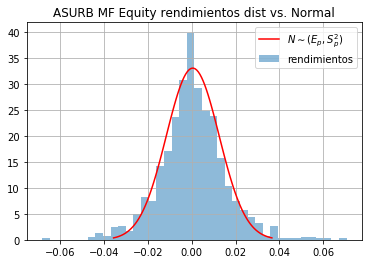

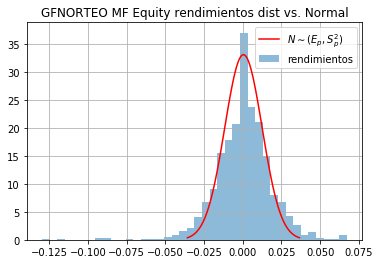

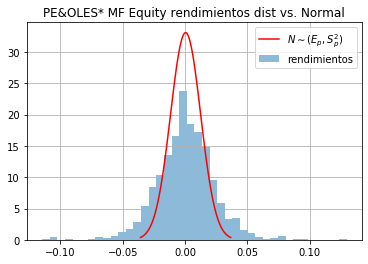

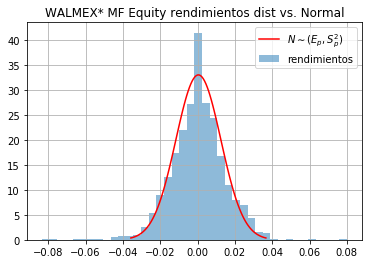

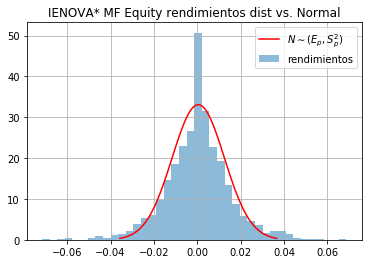

In [19]:
import matplotlib.pyplot as plt
for c in rend.columns:

    # Repeat for each equity in portfolio
    rend[c].hist(bins=40, normed=True,histtype="stepfilled",alpha=0.5,label="rendimientos")
    x = np.linspace(E_p - 3*S_p, E_p+3*S_p,100)
    plt.plot(x, norm.pdf(x, E_p, S_p), "r",label=r"$N\sim(E_p,S_p^2)$")
    plt.legend()
    plt.title(f"{c} rendimientos dist vs. Normal")
    plt.show()    

# VaR al tiempo t

**Si tomamos nuestro VaR diario y lo multiplicamos por $\sqrt(t)$ podemos calcular $VaR_t$**

**si tomamos toda la base de acciones podemos ve la gráfica del VaR al en cada día...**

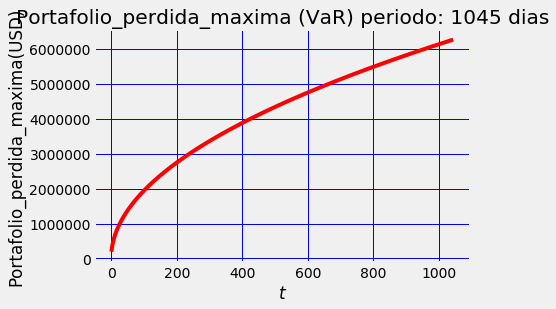

In [20]:
plt.style.use("fivethirtyeight")
# Calculamos VaR al dia t
var_array = []
num_days = int(len(rend))
for x in range(1, num_days+1):    
    var_array.append(np.round(var_95 * np.sqrt(x),2))
    #print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel(r"$t$")
plt.ylabel("Portafolio_perdida_maxima(USD)")
plt.title(f"Portafolio_perdida_maxima (VaR) periodo: {num_days} dias")
plt.plot(var_array, "r")
plt.grid(color="b")

# Conclusiones

**Podemos observar que con respecto al ejercicio del excel, usando los pesos óptimos de sharpe al 95% de confianza el VaR diario se mueve de 161k a 193k por tanto en el portafolio óptimo es mayor en cambio en el anualizado el VaR disminuye de 2.5M a 2M de este modo podemos concluir que nuestro valor al riesgo en el portafolio óptimo cambia según los pesos.**